In [96]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import polars as pl
from rich import print as pp
import os
from pandas import DataFrame

# Import the necessary libraries
import numpy as np
import scipy.stats as sts
import requests
import matplotlib.pyplot as plt
import pyfixest as pf
import itertools
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True, nb_workers=32)
plt.rcParams["font.sans-serif"] = "Liberation Sans"
path_sample = "../data/process/sample.agg.csv"
df = pl.read_csv(path_sample).to_pandas()
# df = df.sample(frac=0.3, random_state=42)
df.head(3)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,text,retweet,reply,like,quote,impression,is_reply,id,created_at,author_id,lang,text_raw,media,date,t,unique_id
0,mom,41.0,6.0,95.0,0.0,0.0,False,7.282756e+17,2016-05-05 17:30:05+00:00,807095.0,en,When your mom takes over your wedding https://...,nytimes,2016-05-05 17:30:05,17,0
1,donald trump jan brewer,142.0,38.0,307.0,0.0,0.0,False,6.987265e+17,2016-02-14 04:32:40+00:00,807095.0,en,"Before Donald Trump, there was Jan Brewer http...",nytimes,2016-02-14 04:32:40,6,1
2,american soccer jordan morri ...,14.0,0.0,0.0,0.0,0.0,False,7.703848e+17,2016-08-29 22:17:03+00:00,807095.0,en,RT @NYTSports: The next big thing in American ...,nytimes,2016-08-29 22:17:03,34,2


Similarity within each window

In [97]:
df_sim = pl.read_csv("../data/process/sim/similarity_scores.csv").to_pandas()
df_sim.head(3)

,unique_id,t,text,similarity_score
0,224,0,"50 comics walk into a club. (No, you haven’t h...",35.856164
1,245,0,A decades-long search for a perfect diet https...,42.676318
2,311,0,"Donald Trump finally buys TV ads, and lots of ...",47.645810


In [98]:
df = df.merge(
    df_sim[["unique_id", "similarity_score", "t"]], on=["t", "unique_id"], how="left"
)
df.head(3)

,text,retweet,reply,like,quote,impression,is_reply,id,created_at,author_id,lang,text_raw,media,date,t,unique_id,similarity_score
0,mom,41.0,6.0,95.0,0.0,0.0,False,7.282756e+17,2016-05-05 17:30:05+00:00,807095.0,en,When your mom takes over your wedding https://...,nytimes,2016-05-05 17:30:05,17,0,46.331763
1,donald trump jan brewer,142.0,38.0,307.0,0.0,0.0,False,6.987265e+17,2016-02-14 04:32:40+00:00,807095.0,en,"Before Donald Trump, there was Jan Brewer http...",nytimes,2016-02-14 04:32:40,6,1,50.306541
2,american soccer jordan morri ...,14.0,0.0,0.0,0.0,0.0,False,7.703848e+17,2016-08-29 22:17:03+00:00,807095.0,en,RT @NYTSports: The next big thing in American ...,nytimes,2016-08-29 22:17:03,34,2,43.727240


## Coding

In [99]:
threshold = np.mean(df["similarity_score"])
pp(f"Threshold: {threshold}")

Threshold: 45.112325046046

<Axes: xlabel='is_unique'>

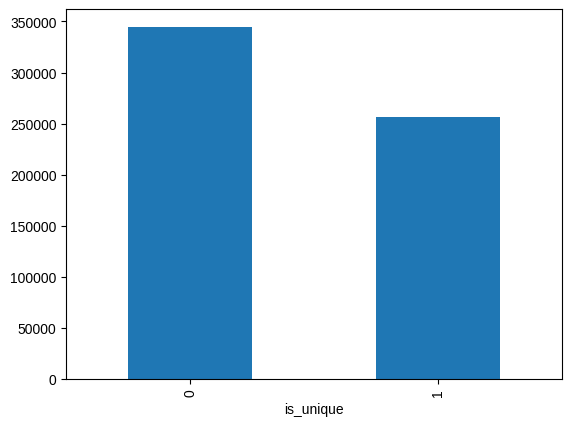

In [100]:
df["is_unique"] = df["similarity_score"].apply(lambda x: 1 if x < threshold else 0)
df.head(3)
df["is_unique"].value_counts()
df["is_unique"].value_counts().plot(kind="bar")

Stat

In [101]:
df_reg = (
    df.groupby(["t", "media"])
    .agg({"is_unique": "sum", "unique_id": "count"})
    .reset_index()
)
df_reg.columns = ["t", "i", "unique_count", "count"]
df_reg["unique_prop"] = df_reg["unique_count"] / df_reg["count"]
df_reg["sim_prop"] = 1 - df_reg["unique_prop"]
df_reg.head(10)

,t,i,unique_count,count,unique_prop,sim_prop
0,0,abc,260,260,1.000000,0.000000
1,0,bbcworld,105,261,0.402299,0.597701
2,0,breitbartnews,33,107,0.308411,0.691589
3,0,buzzfeednews,96,188,0.510638,0.489362
4,0,cbsnews,116,217,0.534562,0.465438
5,0,cnn,136,345,0.394203,0.605797
6,0,dailycaller,109,504,0.216270,0.783730
7,0,dcexaminer,114,426,0.267606,0.732394
8,0,foxnews,224,570,0.392982,0.607018
9,0,guardian,506,968,0.522727,0.477273


In [102]:
df_reg_all_outlets = (
    df_reg.groupby("t").agg({"unique_count": "sum", "count": "sum"}).reset_index()
)
df_reg_all_outlets.columns = ["t", "unique_count_all", "count_all"]
df_reg_all_outlets["unique_prop_all"] = (
    df_reg_all_outlets["unique_count_all"] / df_reg_all_outlets["count_all"]
)
df_reg_all_outlets["sim_prop_all"] = 1 - df_reg_all_outlets["unique_prop_all"]
df_reg_all_outlets.head()

,t,unique_count_all,count_all,unique_prop_all,sim_prop_all
0,0,4316,9566,0.451181,0.548819
1,1,5281,11321,0.466478,0.533522
2,2,5002,11215,0.446010,0.553990
3,3,5014,10765,0.465769,0.534231
4,4,5121,12037,0.425438,0.574562


In [103]:
df_reg_lead = df_reg.copy()
df_reg_lead["t"] = df_reg_lead["t"] - 1
df_reg_lead.head(3)

,t,i,unique_count,count,unique_prop,sim_prop
0,-1,abc,260,260,1.000000,0.000000
1,-1,bbcworld,105,261,0.402299,0.597701
2,-1,breitbartnews,33,107,0.308411,0.691589


In [104]:
df_reg = df_reg.merge(
    df_reg_lead,
    on=["t", "i"],
    how="left",
    suffixes=("", "_lead"),
).merge(
    df_reg_all_outlets,
    on=["t"],
    how="left",
    suffixes=("", "_all"),
)
df_reg.head(3)

,t,i,unique_count,count,unique_prop,sim_prop,unique_count_lead,count_lead,unique_prop_lead,sim_prop_lead,unique_count_all,count_all,unique_prop_all,sim_prop_all
0,0,abc,260,260,1.000000,0.000000,321.0,321.0,1.000000,0.000000,4316,9566,0.451181,0.548819
1,0,bbcworld,105,261,0.402299,0.597701,151.0,320.0,0.471875,0.528125,4316,9566,0.451181,0.548819
2,0,breitbartnews,33,107,0.308411,0.691589,55.0,149.0,0.369128,0.630872,4316,9566,0.451181,0.548819


In [105]:
df_reg["unique_count_comp"] = df_reg["unique_count_all"] - df_reg["unique_count"]
df_reg["unique_count_comp_prop"] = df_reg["unique_count_comp"] / (
    df_reg["count_all"] - df_reg["count"]
)
df_reg = df_reg.dropna()

## Linear regression

In [106]:
# !pip install pyfixest

In [107]:
pp("No FE of media outlets:")
formula = "unique_prop_lead ~ unique_prop + unique_count_comp_prop  | t"
fit = pf.feols(formula, data=df_reg).summary()
pp("FE of media outlets:")
formula = "unique_prop_lead ~ unique_prop  + unique_count_comp_prop  | t + i"
fit = pf.feols(formula, data=df_reg).summary()
# formula = "unique_prop_lead ~ unique_prop + sim_prop + unique_count_comp_prop  | t + i"
# fit = pf.feols(formula, data=df_reg).summary()

No FE of media outlets:

###

Estimation:  OLS
Dep. var.: unique_prop_lead, Fixed effects: t
Inference:  CRV1
Observations:  1300

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| unique_prop            |      0.918 |        0.017 |    54.647 |      0.000 |  0.884 |   0.952 |
| unique_count_comp_prop |     -0.927 |        0.306 |    -3.032 |      0.004 | -1.540 |  -0.313 |
---
RMSE: 0.051 R2: 0.928 R2 Within: 0.922 


FE of media outlets:

###

Estimation:  OLS
Dep. var.: unique_prop_lead, Fixed effects: t+i
Inference:  CRV1
Observations:  1300

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| unique_prop            |      0.681 |        0.036 |    18.787 |      0.000 |  0.609 |   0.754 |
| unique_count_comp_prop |      2.104 |        0.950 |     2.216 |      0.031 |  0.198 |   4.011 |
---
RMSE: 0.046 R2: 0.941 R2 Within: 0.392 


## Structural Estimation

FunctionL calculate moment of a specific order

In [108]:
import scipy as sp
from scipy import stats


### Moment calculation function
def moment(values, order=1) -> float:
    """_summary_

    Args:
        values (_type_): _description_
        level (int, optional): _description_. Defaults to 2.

    Returns:
        float: _description_
    """
    return np.float16(stats.moment(values, order=order))


moment(df_reg["unique_prop"], order=3)

0.002666

Calculate all moments that we concern

In [109]:
df_reg.head(3)

,t,i,unique_count,count,unique_prop,sim_prop,unique_count_lead,count_lead,unique_prop_lead,sim_prop_lead,unique_count_all,count_all,unique_prop_all,sim_prop_all,unique_count_comp,unique_count_comp_prop
0,0,abc,260,260,1.000000,0.000000,321.0,321.0,1.000000,0.000000,4316,9566,0.451181,0.548819,4056,0.435848
1,0,bbcworld,105,261,0.402299,0.597701,151.0,320.0,0.471875,0.528125,4316,9566,0.451181,0.548819,4211,0.452552
2,0,breitbartnews,33,107,0.308411,0.691589,55.0,149.0,0.369128,0.630872,4316,9566,0.451181,0.548819,4283,0.452796


In [110]:
def cal_moments(df=df_reg):
    moment_1 = moment(df["unique_prop_lead"], order=1)
    moment_2 = moment(df["unique_prop_lead"], order=2)
    moment_3 = moment(df["unique_prop"], order=1)
    moment_4 = moment(df["unique_prop"], order=2)
    moment_5 = moment(df["sim_prop"], order=1)
    moment_6 = moment(df["sim_prop"], order=2)
    moment_7 = moment(df["unique_count_comp_prop"], order=1)
    moment_8 = moment(df["unique_count_comp_prop"], order=2)
    return np.array(
        [moment_1, moment_2, moment_3, moment_4, moment_5, moment_6, moment_7, moment_8]
    )


cal_moments()

array([0.     , 0.0359 , 0.     , 0.0355 , 0.     , 0.0355 , 0.     ,
       0.00266], dtype=float16)

Calculate the difference

In [111]:
def diff_moments(moments_model, moments_data=cal_moments()):
    diff = moments_data - moments_model
    return diff


diff_moments(moments_model=cal_moments(df_reg.sample(frac=0.3, random_state=42)))

array([ 0.000e+00,  4.456e-03,  0.000e+00,  4.059e-03,  0.000e+00,
        4.059e-03,  0.000e+00, -1.144e-05], dtype=float16)

Loss function

In [112]:
def obj_func(df, parameters=[0.1, 0.2, 0.3], W=None, moments_data=cal_moments()):
    if W is None:
        W = np.eye(cal_moments().shape[0])
    dv = "unique_prop_lead"
    x1 = "unique_prop"  # alpha
    x2 = "sim_prop"  # beta
    x3 = "unique_count_comp_prop"  # theta
    # a. set parameters
    alpha = parameters[0]
    beta = parameters[1]
    theta = parameters[2]
    df.loc[:, dv] = df.loc[:, x1] * alpha + df.loc[:, x2] * beta + df.loc[:, x3] * theta
    moments_model = cal_moments(df)

    # b. calculate difference
    moments_diff = diff_moments(moments_model, moments_data)

    # c. calculate objective

    obj = moments_diff @ W @ moments_diff

    # d. print

    # pp(f"{'/'.join(parameters)} -> {obj:12.8f}")

    return alpha, beta, obj


obj_func(df_reg, [0.3, 0.2, 0.1])

(0.3, 0.2, 0.0012596780434250832)

In [113]:
num_options = 30
alphas = np.linspace(0, 3, num_options)
betas = np.linspace(-3, 0, num_options)
thetas = np.linspace(-3, 3, num_options)

df_results = pd.DataFrame(itertools.product(alphas, betas, thetas))
df_results.columns = ["alpha", "beta", "theta"]
df_results["obj"] = df_results.parallel_apply(
    lambda x: obj_func(df_reg, [x["alpha"], x["beta"], x["theta"]])[2], axis=1
)
df_results = df_results.sort_values("obj")
top_results = df_results.head(10)


top_results.head(10)

/home/rongxin/anaconda3/envs/data/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  self.pid = os.fork()


,alpha,beta,theta,obj
2466,0.206897,-0.724138,-1.758621,8.381903e-09
1536,0.103448,-0.827586,-1.758621,8.381903e-09
4326,0.413793,-0.517241,-1.758621,8.381903e-09
7116,0.724138,-0.206897,-1.758621,8.381903e-09
5256,0.517241,-0.413793,-1.758621,8.381903e-09
6186,0.620690,-0.310345,-1.758621,8.381903e-09
606,0.000000,-0.931034,-1.758621,8.381903e-09
3396,0.310345,-0.620690,-1.758621,8.381903e-09
8046,0.827586,-0.103448,-1.758621,8.381903e-09
8976,0.931034,0.000000,-1.758621,8.381903e-09


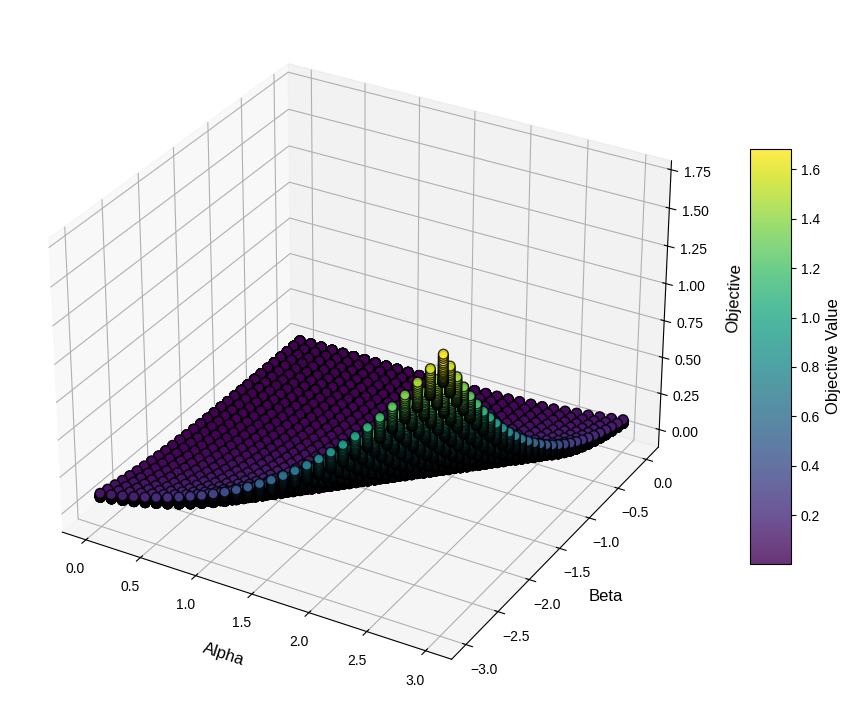

In [120]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot with enhanced aesthetics
sc = ax.scatter(
    df_results["alpha"],
    df_results["beta"],
    df_results["obj"],
    c=df_results["obj"],
    cmap="viridis",
    edgecolor="k",
    s=50,
    alpha=0.8,
)

# Labels and title
ax.set_xlabel("Alpha", fontsize=12, labelpad=10)
ax.set_ylabel("Beta", fontsize=12, labelpad=10)
ax.set_zlabel("Objective", fontsize=12, labelpad=10)
ax.set_title("", fontsize=14, pad=15)

# Color bar for better interpretation
cbar = fig.colorbar(sc, ax=ax, shrink=0.6, aspect=10)
cbar.set_label("Objective Value", fontsize=12)

# Improve layout
ax.grid(True)
plt.show()

In [119]:
pp(f"Best parameters: {df_results.iloc[0].values}")
pp(f"Best objective: {df_results.iloc[0]['obj']}")
pp(
    f"The formula: {df_results.iloc[0]['alpha']:3f} * unique_prop + {df_results.iloc[0]['beta']:3f} * sim_prop + {df_results.iloc[0]['theta']:3f} * unique_count_comp_prop"
)

Best parameters: [ 2.06896552e-01 -7.24137931e-01 -1.75862069e+00  8.38190317e-09]

Best objective: 8.381903171539307e-09

The formula: 0.206897 * unique_prop + -0.724138 * sim_prop + -1.758621 * unique_count_comp_prop